In [1]:
import numpy as np
from qiskit.transpiler import CouplingMap
from generic_spillover_noise import circuit_context, noisy_backend

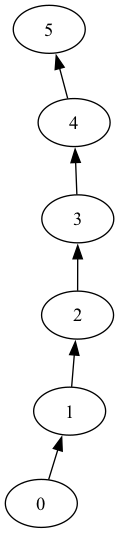

In [2]:
# Define the number of qubits
num_qubits = 6
cm = CouplingMap.from_line(num_qubits, False)
cm.draw()

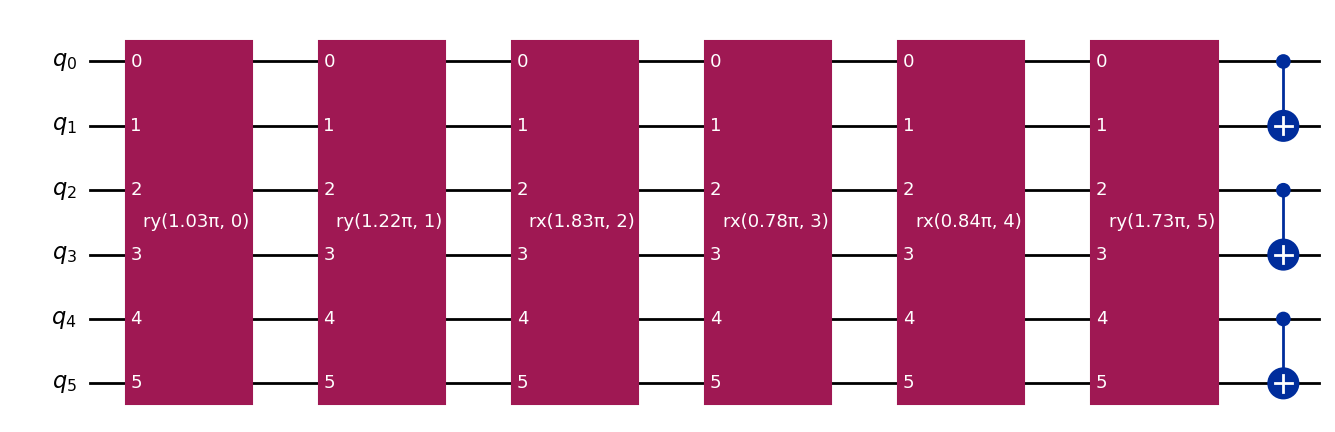

In [3]:
# Define parameters for U(phi) gates
# phi_rotation_values = np.pi * np.array([0.25, 0.5, 0.75, 1])
# phi_arr = np.random.choice(phi_rotation_values, size=num_qubits)
rotation_angles = np.random.uniform(0, 2 * np.pi, size=num_qubits)
# gate_types = ['RY', 'RY', 'RX', 'RX', 'RX', 'RY']
sq_gates = {0: "ry", 1: "ry", 2: "rx", 3: "rx", 4: "rx", 5: "ry"}  # {qubit: gate_type}

# Create the quantum circuit
qc = circuit_context(num_qubits, list(sq_gates.values()), rotation_angles,
                     coupling_map=cm)

# Display the circuit structure
qc.draw("mpl")

In [4]:
# Define noise-coupling matrix with gamma values (example values)
gamma_matrix = np.zeros((num_qubits, num_qubits))
gamma_matrix[0, 1] = 0.025  # γ_0->1
gamma_matrix[1, 2] = 0.025  # γ_1->2
gamma_matrix[2, 3] = 0.025  # γ_2->3
gamma_matrix[3, 2] = 0.025  # γ_3->2
gamma_matrix[4, 3] = 0.025  # γ_4->3
gamma_matrix[5, 4] = 0.025  # γ_5->4

gamma_matrix

array([[0.   , 0.025, 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.025, 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.025, 0.   , 0.   ],
       [0.   , 0.   , 0.025, 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.025, 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.025, 0.   ]])

In [ ]:
# Create the noisy backend tailored for spillover noise
backend = noisy_backend(num_qubits, list(sq_gates.values()), rotation_angles, gamma_matrix)

In [20]:
backend

AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['ry(0.47π, 1)', 'ry(1.69π, 5)', 'rx(1.53π, 4)', 'rx(0.86π, 3)', 'ry(1.32π, 0)', 'rx(1.94π, 2)']>)